In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
snps = pd.read_excel('S2_SNP.xlsx', sheet_name='SNP RNA editing site')
# snps_n = pd.read_excel('S2_SNP.xlsx', sheet_name='Non-SNP RNA editing site')

In [16]:
snps = snps.sort_values(['Chr', 'Position'])
snps = snps.drop(['chr1', 'start', 'end'], axis=1)
# snps_n = snps_n.sort_values(['Chr', 'Position'])

In [17]:
snps

,Chr,Position,Strand,Reference allele,Alternative allele,Ensembl ID,Gene symbol,Annotation,Alu ?
0,chr1,909242,+,A,G,ENSG00000187583,PLEKHN1,CDS,N
1,chr1,982444,+,A,G,ENSG00000188157,AGRN,intronic,N
2,chr1,990417,-,T,C,-,-,antisense,N
3,chr1,1104418,+,A,C,ENSG00000198976,MIR429,ncRNA,N
4,chr1,1156131,-,T,C,ENSG00000078808,SDF4,ncRNA,N
...,...,...,...,...,...,...,...,...,...
7785,chrX,138633280,+,A,G,ENSG00000101981,F9,CDS,N
7786,chrX,139873279,-,T,C,-,-,intergenic,N
7787,chrX,151122248,-,T,C,ENSG00000102287,GABRE,3'UTR,N
7788,chrX,151122772,+,A,G,-,-,antisense,N


In [18]:
def get_bed(snp, reg_size : int):
    snp['l_break'] = snps['Position'] - reg_size
    snp['r_break'] = snps['Position'] + reg_size
    snp['bed'] = snp['Chr'].map(str) + "\t" + snp['l_break'].map(int).map(str) + "\t" \
        + snp['r_break'].map(int).map(str) + "\n"
    with open('snp_regs.bed', 'w') as file:
        out = ''.join(snp['bed'])
        file.write(out)
    snp = snp.drop(['bed'], axis=1)
    return snp

In [19]:
r_list = list([500])
list_zform = list()
for i in r_list:
    snps = get_bed(snps, i)
    #DeepZ
    !bedtools intersect -a snp_regs.bed -b DeepZ.bed -wo > 'snps-in-zhunt.bed'
    f = open('snps-in-zhunt.bed', 'r')
    res = [i.split('\t') for i in f.read().split('\n')][:-1]
    res_left_fr = pd.DataFrame(res)[[1, 6]]
    res_left_fr.columns = ['l_break', 'int_size']
    res_left_fr['l_break'] = res_left_fr['l_break'].map(int)
    res_left_fr = res_left_fr.sort_values('l_break')
    beg_int = res_left_fr['l_break']
    zhunt_int_snp = snps[snps['l_break'].isin(map(int, beg_int))].sort_values('l_break')
    zhunt_int_snp = zhunt_int_snp.merge(res_left_fr, on='l_break')
    zhunt_int_snp['int_size'] = zhunt_int_snp['int_size'].map(int)
    lt = pd.DataFrame([zhunt_int_snp.groupby('Annotation').count()['Position'], \
            snps.groupby('Annotation').count()['Position']])
    t = lt.fillna(0).T.astype(int)
    t.columns = ['DeepZ', 'ALL']
#     zhunt 
#     !bedtools intersect -a snp_regs.bed -b zhunt.bed -wo > 'snps-in-zhunt.bed'
#     f = open('snps-in-zhunt.bed', 'r')
#     res = [i.split('\t') for i in f.read().split('\n')][:-1]
#     res_left_fr = pd.DataFrame(res)[[1, 6]]
#     res_left_fr.columns = ['l_break', 'int_size']
#     res_left_fr['l_break'] = res_left_fr['l_break'].map(int)
#     res_left_fr = res_left_fr.sort_values('l_break')
#     beg_int = res_left_fr['l_break']
#     zhunt_int_snp = snps[snps['l_break'].isin(map(int, beg_int))].sort_values('l_break')
#     zhunt_int_snp = zhunt_int_snp.merge(res_left_fr, on='l_break')
#     zhunt_int_snp['int_size'] = zhunt_int_snp['int_size'].map(int)
#     lt = pd.DataFrame([zhunt_int_snp.groupby('Annotation').count()['Position'], \
#             snps.groupby('Annotation').count()['Position']])
#     t1 = lt.fillna(0).T.astype(int)
#     t1.columns = ['zhunt', 'ALL']
#     t1 = t1.reset_index()
#     t = t.reset_index()
#     res = t.merge(t1)
#     res = res.set_index('Annotation')
#     res.plot(kind='bar', logy=True, rot=45, title=f'Annotation for {i} SNP region', figsize=(15,10), fontsize=15)

In [20]:
# pd.DataFrame([r_list, list_zform]).T.plot(x=0, y=1, kind='line', legend=False, figsize=(10, 7))

In [21]:
zhunt_int_snp.groupby('Annotation').count()['Position']

Annotation
3'UTR         12
5'UTR         27
CDS           14
antisense     69
intergenic    10
intronic      15
ncRNA          9
Name: Position, dtype: int64

In [22]:
snps.groupby('Annotation').count()['Position']

Annotation
3'UTR         1716
5'UTR           86
CDS            527
antisense     1733
intergenic     660
intronic      2657
ncRNA          411
Name: Position, dtype: int64

In [23]:
len(zhunt_int_snp)

156

In Gene and Not In Gene

In [24]:
len(zhunt_int_snp[zhunt_int_snp['Gene symbol'] != '-'])

77

In [25]:
len(zhunt_int_snp[zhunt_int_snp['Gene symbol'] == '-'])

79

In [26]:
zhunt_int_snp['Alu ?'].value_counts()

N    139
Y     17
Name: Alu ?, dtype: int64

In [27]:
# res_zhunt = zhunt_int_snp[zhunt_int_snp['Gene symbol'] != '-'].sort_values(\
#                             'int_size').sort_values(['int_size', 'Chr', \
#         'Strand', 'Position']).reset_index().drop(['index'], axis=1)

res_zhunt = snps[snps['Gene symbol'] != '-'].sort_values(['Chr', \
        'Strand', 'Position']).reset_index().drop(['index'], axis=1)

# (zhunt_int_snp['Strand'] == '+')
# (zhunt_int_snp['int_size'] >= zhunt_int_snp['int_size'].mean()) 
# res_zhunt.to_csv('DeepZ_snp_genes_2000_window.csv')
df_n = res_zhunt[['Chr', 'Ensembl ID', 'l_break', 'r_break']]
df_n

,Chr,Ensembl ID,l_break,r_break
0,chr1,ENSG00000187583,908742,909742
1,chr1,ENSG00000188157,981944,982944
2,chr1,ENSG00000198976,1103918,1104918
3,chr1,ENSG00000215915,1404309,1405309
4,chr1,ENSG00000160072,1418561,1419561
...,...,...,...,...
5392,chrX,ENSG00000005893,119566199,119567199
5393,chrX,ENSG00000005893,119571041,119572041
5394,chrX,ENSG00000188706,128949561,128950561
5395,chrX,ENSG00000123728,131341665,131342665


In [28]:
res_zhunt = snps.sort_values(['Chr', \
        'Strand', 'Position']).reset_index().drop(['index'], axis=1)

df_n = res_zhunt[['Chr', 'Gene symbol', 'l_break', 'r_break']]
df_n

,Chr,Gene symbol,l_break,r_break
0,chr1,PLEKHN1,908742,909742
1,chr1,AGRN,981944,982944
2,chr1,MIR429,1103918,1104918
3,chr1,-,1209852,1210852
4,chr1,-,1289908,1290908
...,...,...,...,...
7785,chrX,-,128927390,128928390
7786,chrX,ZDHHC9,128949561,128950561
7787,chrX,RAP2C,131341665,131342665
7788,chrX,-,139872779,139873779


In [29]:
import requests

def get_hg19_seq(chrm1, seq_from1, seq_to1):
    rs = list()
    for i in range(len(chrm1)):
        print(i)
        chrm = chrm1[i]
        seq_from = seq_from1[i]
        seq_to = seq_to1[i]
        base_url = "http://genome.ucsc.edu/cgi-bin/das/hg19/dna?segment="
        page = requests.get(base_url + str(chrm) + ":" + str(seq_from) + "," + str(seq_to))
        contents = []
        for line in page.text.split('\n'):
            if "<" not in line:
                contents.append(line.rstrip())
        full_seq = "".join(contents).upper()
        rs.append(full_seq)
        full_seq = ""
    return rs

In [ ]:
df_n = df_n.assign(seq=lambda x: get_hg19_seq(x.Chr, x.l_break, x.r_break))
df_n = df_n.drop_duplicates('Ensembl ID')
df_n

In [31]:
df_n

,Chr,Gene symbol,l_break,r_break,seq
0,chr1,PLEKHN1,908742,909742,TTCCCACCGTTCCGCACCACTGGTCTCTGTCTCTGGGCCCAGTTGT...
1,chr1,AGRN,981944,982944,ACTGCCAGCGTCCCCAGGACCACCGTGTGGCCCGTGCTGACGGTGC...
2,chr1,MIR429,1103918,1104918,AGGGGTCTCATTCCTTCCCCCAGTCAACAAGAACAGGAACTTTGTC...
3,chr1,-,1209852,1210852,GGAGAGAGCGGTAGGTGGCGGGGCGCTGGGGTGGGACGCTGGGGGC...
4,chr1,-,1289908,1290908,CGGGGCGGCGTCAGGTACCAGCAAGACCTGCGCCCCGACCCGGGCC...
...,...,...,...,...,...
7785,chrX,-,128927390,128928390,AGCCAGGATTCAAGCCCACTGCCTGGCTCCAGCTTAGTGCTAAAGA...
7786,chrX,ZDHHC9,128949561,128950561,GATTTGCATTTCCTTGGTGATCAATGATGTGATTATTACACATTGC...
7787,chrX,RAP2C,131341665,131342665,GCTTGCATTAAACAAAAACAACAGTCTCTTTCAGGTTAGAATTTCA...
7788,chrX,-,139872779,139873779,GACCTTTGAGTAACATGTCAAGAACTGCCATCTTTATGATAGTGGG...


In [32]:
df_n['seq'][0]

'TTCCCACCGTTCCGCACCACTGGTCTCTGTCTCTGGGCCCAGTTGTCCTGGAGCCACCCAGAGGCCTCTTGCACAGAGAAGGGGTGGCCTAGGCTGTTTCTAGCCGAGAAGCCCATTTCTCCCACCTCTGCCCTGCAGCTGCACAGGCTGAGCCTGGAGAGCAGCCCAGATGCCCCTGACCACACTTCGGAAACATCACACTCGCCCCTCTATGCCGACCCCTACACACCACCCGCCACCTCCCACCGCAGGGTCACAGATGTCCGGGGCCTGGAGGAGGTCAGGCCCCTGCTGGGTGACAGAAAGGGTGGGAGGTGCCTGCAGCCTGAGGCTGGGGAGGTCTAGACCGTGCGTCTCACCCTGGGGTCTGGGGCTGCCCCAAGCCTGAGGTCTGTTCAGGCTCTGATGGGAGGTTGAGGTTCTGGGGGCCCCTGGCTGCCACCCAGGCCCCAGCCCTGGCTCTCCCTGCAGTTCCTCAGTGCCATGCAGAGTGCACGTGGACCCACGCCCTCGAGCCCACTCCCCTCGGTGCCTGTGTCTGTGCCTGCCTCTGACCCTCGCTCCTGCTCCTCCGGCCCCGCTGGCCCCTACTTGCTCTCCAAGAAGGGAGCCCTGCAGTCCAGAGCCGCTCAGAGACACCGGGGCTCAGCCAAGGATGGGGGGCCGCAGCCCCCAGACGCCCCTCAGCTTGTGAGTAGCAGCCCCCACGCCCGTGTGCCCCGGGCTCCGGGCTGGCCGGGGGTCTGGTGTGGGGCCTCTTGGGACTCTGAGGGAGCAGGGAGGGAAACAGGAGGACGGGGGCAGATGGAGGCCAGGGGGGCCAGTAGGGAGTTGGGGAGATGGGACTGGGGAGGGAGAGCAGGGGGACATGGGGGGCTGCACAGTGACAGGCCGCCTCCAAGCTCCCTGCCTGGGGCTGTGCCCGGCTCTCAGACTTGCGGTTTGGGGTTCCAGGTCTCCTCTGCCAGGGAAGGTTCGCCCGAACCCTGGCTGCCTCTG

In [40]:
df_n.to_csv('ALL_SNP_seq.csv')

In [41]:
def func(name, name1, seq):
    with open(f'./ALL_seq_1000/{str(name)}_{str(name1)}.fa', 'w+') as f:
        f.write('>' + str(name) + '_' + str(name1) + '\n')
        f.write(seq + '\n')

In [42]:
def func1(name, seq, f):
        f.write('>' + name + '\n')
        f.write(seq + '\n')

In [43]:
def func2(name, name1, seq, f):
        f.write('>' + str(name) + '_' + str(name1) + '\n')
        f.write(seq + '\n')

In [44]:
with open(f'./ALL_seq_1000.fa', 'w+') as f:
    df_n.apply(lambda x: func2(x['Gene symbol'], x['l_break'], x['seq'], f), axis=1)

In [45]:
df_n.apply(lambda x: func(x['Gene symbol'], x['l_break'], x['seq']), axis=1)

0       None
1       None
2       None
3       None
4       None
        ... 
7785    None
7786    None
7787    None
7788    None
7789    None
Length: 7790, dtype: object

In [ ]:
for i in df_n[['Gene symbol', 'l_break']].iterrows():
    s = str(i[1]['Gene symbol']) + '_' + str(i[1]['l_break']) + '.fa'
    !./zhunt_alan 8 6 8 ./ALL_seq_1000/{s}

In [ ]:
with open('ALL_SNPs_zscore_200', 'w+') as f:
    for i in df_n[['Gene symbol', 'l_break']].iterrows():
        s = str(i[1]['Gene symbol']) + '_' + str(i[1]['l_break']) + '.fa'
        df_z = pd.read_table(f'./ALL_seq_1000/{s}.Z-SCORE', sep=r'\s{1,}', names=[1,2,3,4,5,6,7,8])
        df_z = df_z.fillna(0)
        if sum(df_z[6] > 200) != 0:
            f.write('>' + str(i[1]['Gene symbol']) + '_' + str(i[1]['l_break'] + 500) + '\t' + str(max(df_z[6])) + '\n')


In [147]:
# процентов снипов содержат участки с zscore > 200
# (NEW with 1000 gap)
3441 / 7790

# >PTTG1IP_46273010	60248.626161
# >PMPCA_139317917	63591.236745
# >PMPCA_139317921	63591.236745
# >ZNF852_44551920	66470.780662
# >ZNF26_133562966	68804.913166
# >-_61519931	71225.210852
# >-_88117914	80064.906768
# >FAM13A-AS1_89649341	102091.882534
# >PLEKHF2_96145993	120360.666014
# >-_38513504	158050.762443
# >YPEL2_57477922	184276.922761
# >SMAD4_48610324	4044150.905303

0.20089858793324775

In [182]:
with open('./top_10/SMAD4.fa', 'w+') as f:
    t = df_n[(df_n['Gene symbol'] == 'SMAD4') & (df_n['l_break'] == 48610324)]
    f.write('>' + t['Gene symbol'].iloc[0] + '_' + str(t['l_break'].iloc[0]) + '\n')
    f.write(t['seq'].iloc[0])
    

In [187]:
for i in ['PTTG1IP.fa', 'PMPCA.fa', 'ZNF852.fa', 'ZNF26.fa', '-_61519931.fa', '-_88117914.fa', \
         'FAM13A-AS1.fa', 'PLEKHF2.fa', '-_38513504.fa', 'YPEL2.fa', 'SMAD4.fa']:
    !cd top_10_fold && RNAfold -p -d2 --noLP < ../top_10/{i} > {i.split('.')[0]}

In [188]:
# for i in df_n['Ensembl ID']: 
for i in ['PTTG1IP_46273010', 'PMPCA_139317917', 'ZNF852_44551920',\
          'ZNF26_133562966', '-_61519931', '-_88117914', \
         'FAM13A-AS1_89649341', 'PLEKHF2_96145993', '-_38513504', 'YPEL2_57477922', 'SMAD4_48610324']:
    !perl relplot.pl -p top_10_fold/{i}_ss.ps top_10_fold/{i}_dp.ps > top_10_fold/{i}_rss.ps
    !rm top_10_fold/{i}_ss.ps
    !rm top_10_fold/{i}_dp.ps
    !rm zhunt_fold/{i}

In [82]:
chart = pd.read_table('pantherChart.txt', names=[1,2,3,4,5])
chart = chart[[2,3]]
chart = chart.set_index(2)
chart

,3
2,
binding (GO:0005488),8
structural molecule activity (GO:0005198),1
molecular function regulator (GO:0098772),6
catalytic activity (GO:0003824),5
transporter activity (GO:0005215),1


<AxesSubplot:title={'center':'Panter GO-Slim Molecular Function for DeepZ Genes'}>

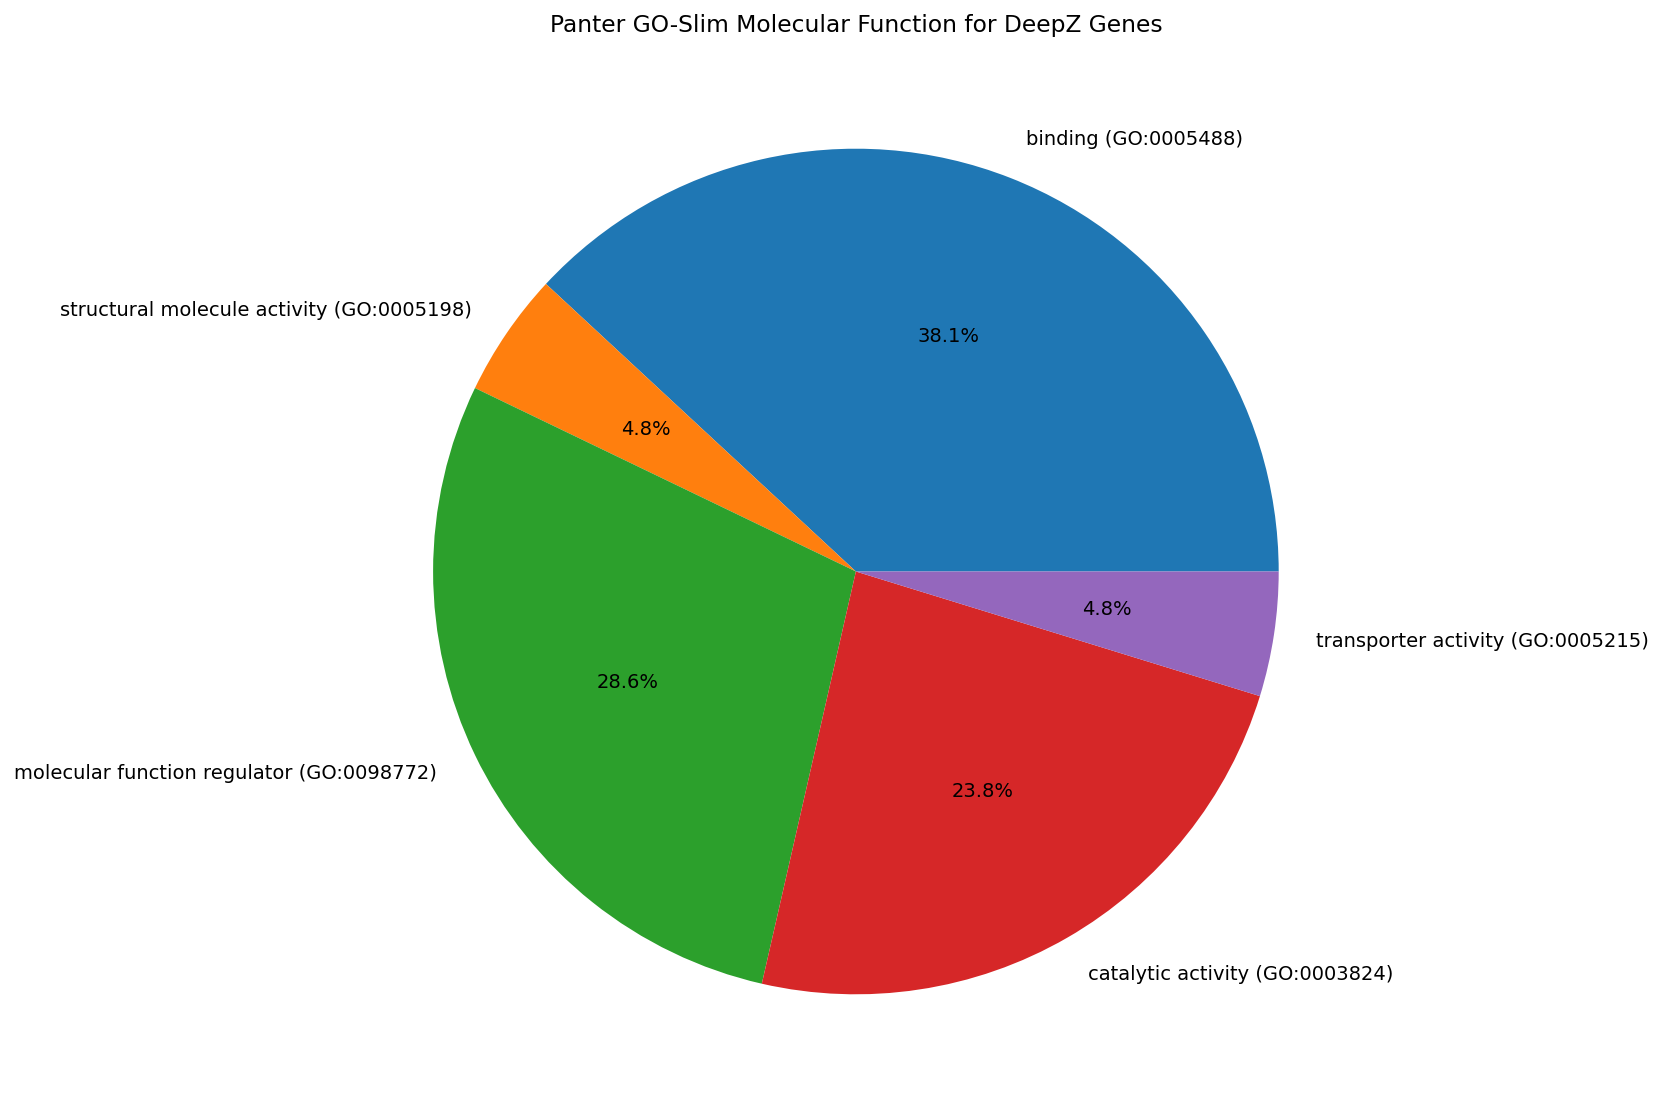

In [84]:
fig = plt.figure(dpi=140)
chart.plot(kind='pie', y=3, title=f'Panter GO-Slim Molecular Function for DeepZ Genes', figsize=(15,10), fontsize=10, legend=False,\
          ylabel='', autopct='%1.1f%%', ax=plt.gca())